In [1]:
# !pip install "xmip>=0.7.1" #new version raises much less warnings but not required for proper functionality.

In [2]:
import numpy as np
import intake
import fsspec
import xarray as xr

from matplotlib import pyplot as plt
from xarrayutils.plotting import shaded_line_plot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [4]:
sorted([eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid])

['esm-ssp585',
 'esm-ssp585-ssp126Lu',
 'ssp119',
 'ssp126',
 'ssp126-ssp370Lu',
 'ssp245',
 'ssp245-GHG',
 'ssp245-aer',
 'ssp245-cov-fossil',
 'ssp245-cov-modgreen',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp245-nat',
 'ssp245-stratO3',
 'ssp370',
 'ssp370-lowNTCF',
 'ssp370-ssp126Lu',
 'ssp370SST',
 'ssp370SST-lowCH4',
 'ssp370SST-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370pdSST',
 'ssp434',
 'ssp460',
 'ssp534-over',
 'ssp585',
 'ssp585-bgc']

[Reference Spreadsheet for variable names](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271)

In [5]:
query = dict(
    experiment_id=['historical','ssp126','ssp245', 'ssp370', 'ssp585'],
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)

col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id", "grid_label"]
].nunique()

/srv/conda/envs/notebook/lib/python3.10/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id,grid_label
source_id,,,,
ACCESS-CM2,5,1,1,1
AWI-CM-1-1-MR,5,1,1,1
BCC-CSM2-MR,5,1,1,1
CAMS-CSM1-0,5,1,1,1
CAS-ESM2-0,5,1,1,1
CESM2-WACCM,5,1,1,1
CMCC-CM2-SR5,5,1,1,1
CMCC-ESM2,5,1,1,1
CanESM5,5,1,1,1


In [6]:
from xmip.preprocessing import combined_preprocessing
ddict = col_subset.to_dataset_dict(
    aggregate=False,
    xarray_open_kwargs={'use_cftime':True},
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'height'
  warnings.warn(f"Renaming failed with {e}")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'tas'
  warnings.warn(f"Renaming failed with {e}")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'height'
  warnings.warn(f"Renaming failed with {e}")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'tas'
  warnings.warn(f"Renaming failed with {e}")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'height'
  warnings.warn(f"Renaming failed with {e}")
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:106: UserWarning: Renaming failed with 'tas'
  warnings.warn(f"Renaming failed with {

In [7]:
def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['x','y'], keep_attrs=True)

timeseries = {k: global_mean(ds) for k,ds in ddict.items()}

In [8]:
timeseries['CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Amon.tas.gn.gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/.nan.20181126']

<xarray.Dataset>
Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    height          float64 2.0
    tas             (member_id, dcpp_init_year, time) float64 dask.array<chunksize=(1, 1, 600), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2289.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/h...
    intake_esm_attrs:version:         20181126
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f...

In [9]:
# calculate annual averages
timeseries_annual = {
    k: ds.sortby('time').
    convert_calendar('standard', align_on='year', use_cftime=True).
    resample(time='1AS').mean()
    .sel(time=slice(None, '2060')) 
    for k,ds in timeseries.items()
}

In [10]:
timeseries_annual['CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1.Amon.tas.gn.gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/tas/gn/v20181126/.nan.20181126']

<xarray.Dataset>
Dimensions:         (time: 165, member_id: 1, dcpp_init_year: 1)
Coordinates:
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * time            (time) object 1850-01-01 00:00:00 ... 2014-01-01 00:00:00
Data variables:
    height          (time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    tas             (member_id, dcpp_init_year, time) float64 dask.array<chunksize=(1, 1, 50), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2289.0
    cmor_version:                     3.3.2
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/h...
    intake_esm_attrs:version:         20181126
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f...

## remove this part for debugging only

In [18]:
from xmip.postprocessing import combine_datasets
def combine_func(ds_list):    
    ds_list_w_coords = [ds[['tas']].squeeze().assign_coords(source_id=ds.attrs.get('source_id')) for ds in ds_list]
    return xr.concat(ds_list_w_coords, dim='source_id')
    
experiments_combined = combine_datasets(timeseries_annual, combine_func, match_attrs=['experiment_id'])

In [137]:
from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42161,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.65 GiB
Comm: tcp://127.0.0.1:42597,Total threads: 1
Dashboard: /user/jbusecke/proxy/38237/status,Memory: 3.66 GiB
Nanny: tcp://127.0.0.1:38853,


In [20]:
# load the data into memory
experiments_combined_loaded = {k:ds.load() for k,ds in experiments_combined.items()}

In [21]:
for ex, ds in experiments_combined_loaded.items():
    print(len(ds.source_id))

27
27
27
27
27


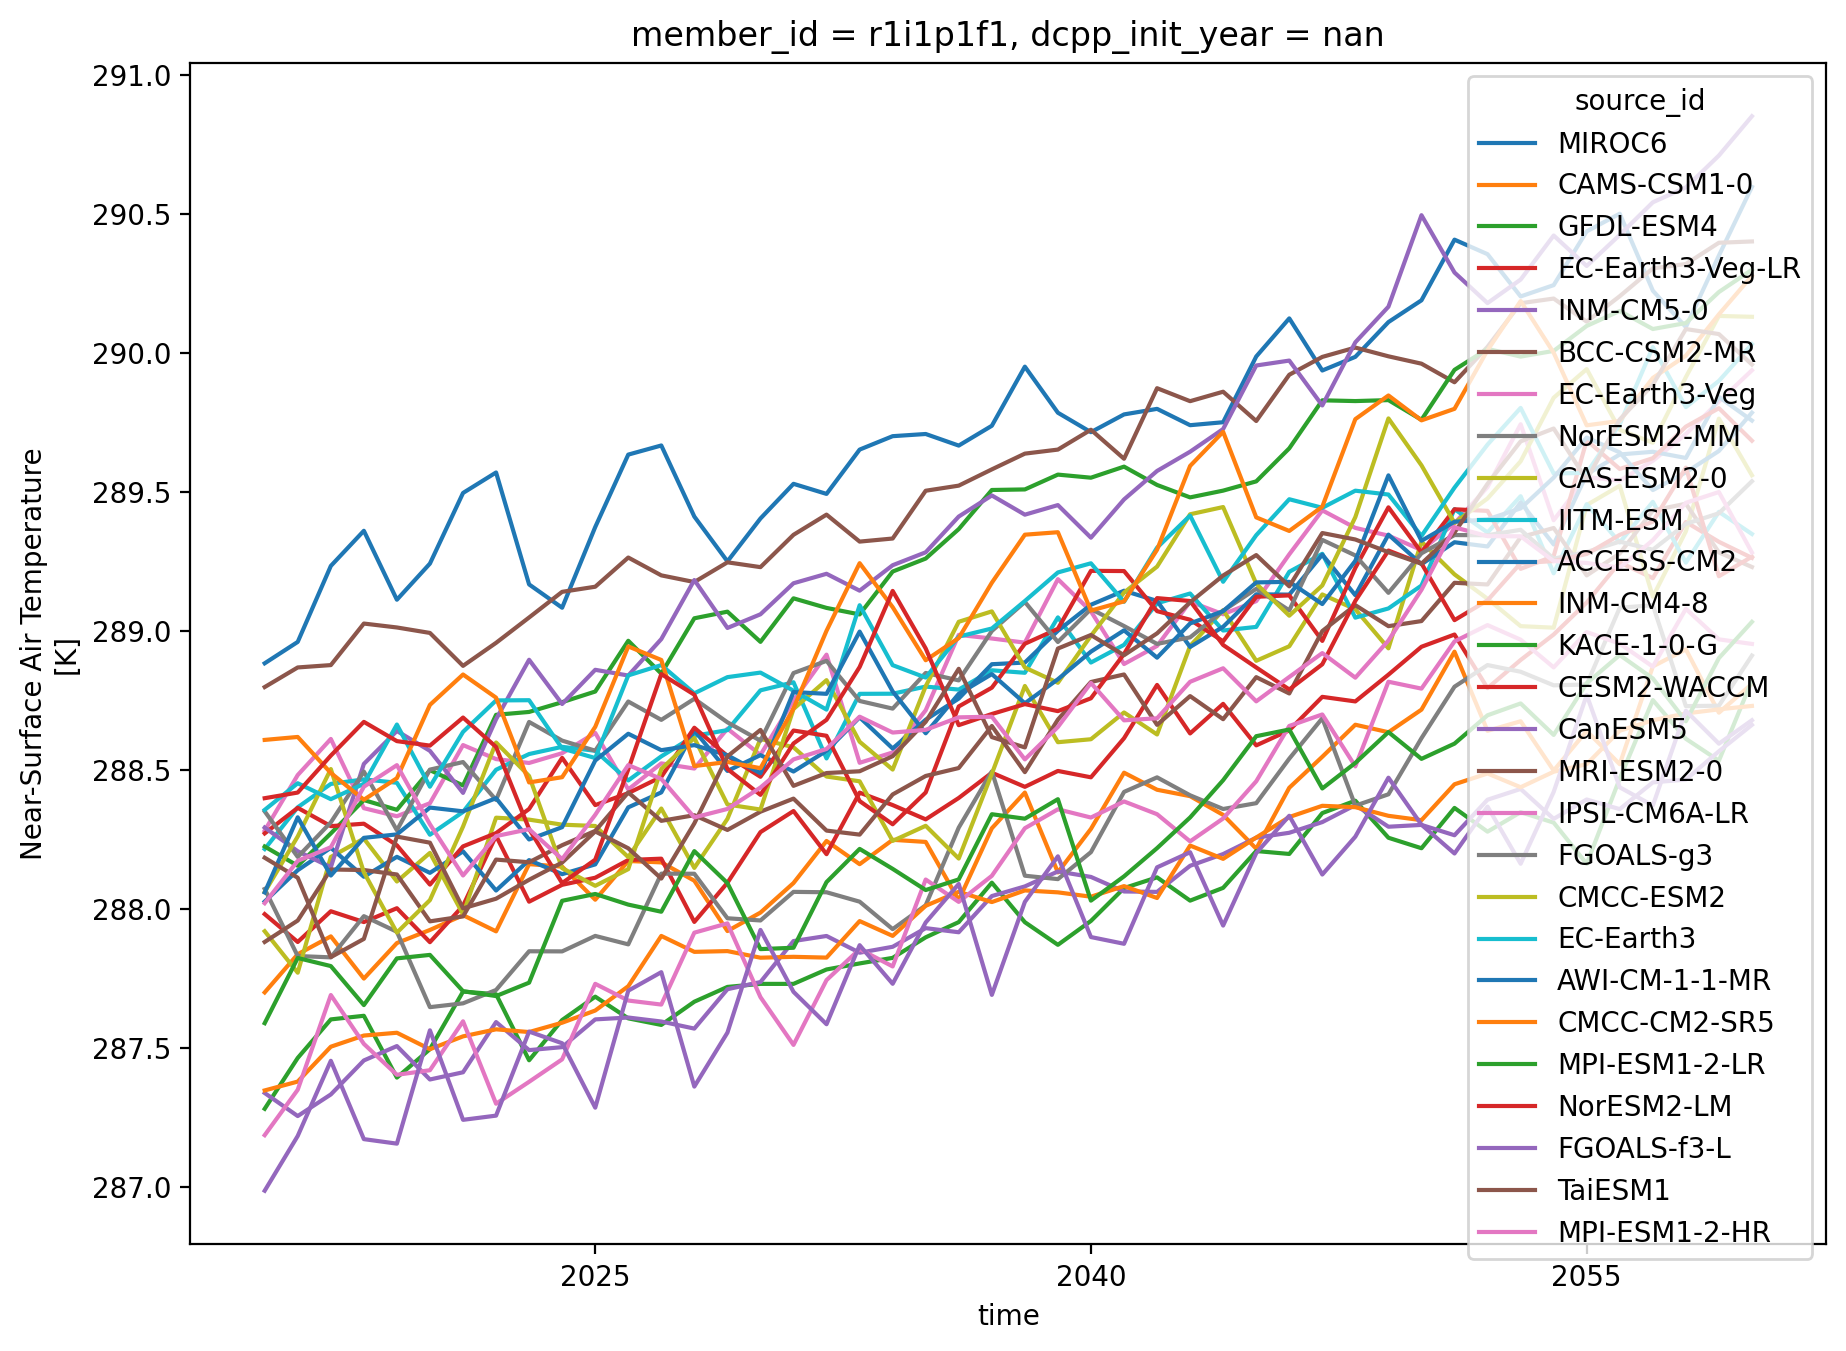

In [26]:
experiments_combined['ssp370'].tas.plot(hue='source_id', size=7);
plt.tight_layout()

## Almost Pierre's Plot 😄

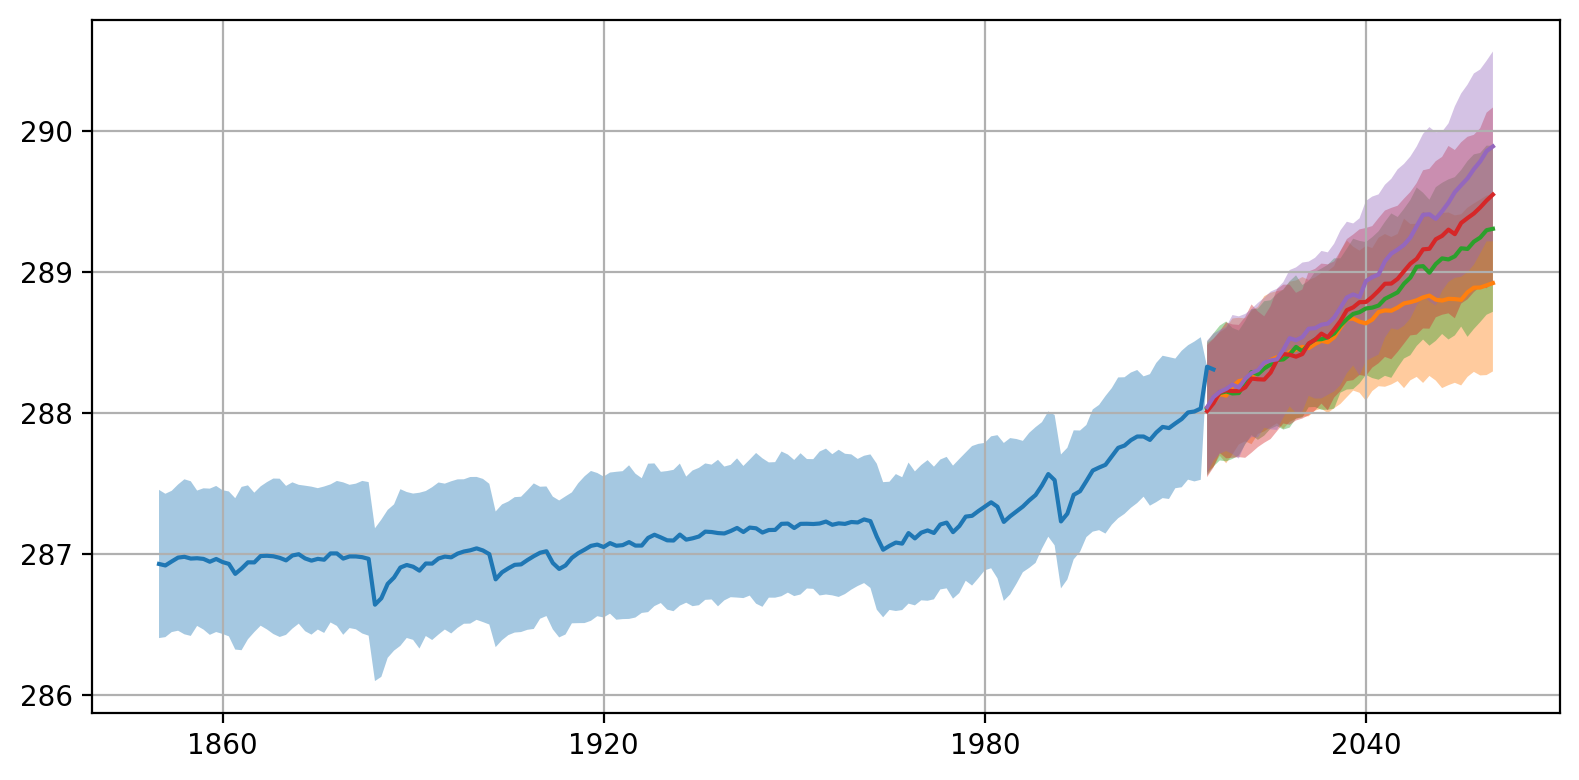

In [27]:
color_dict = {'historical':'0.3', 'ssp126':'C1', 'ssp245':'C2', 'ssp370':'C3', 'ssp585':'C4'}
plt.figure(figsize=[8, 4])
for experiment, color in color_dict.items():
    ds = experiments_combined[experiment].squeeze()
    shaded_line_plot(ds.tas, 'source_id', spreads = [2])
plt.tight_layout()
plt.grid()

## How about the anomalies?

In [28]:
path_gisstemp = "https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz"
with fsspec.open(path_gisstemp, compression='infer') as f:
    ds_giss = xr.open_dataset(f, use_cftime=True).load()
    
def global_mean_giss(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lon','lat'], keep_attrs=True)

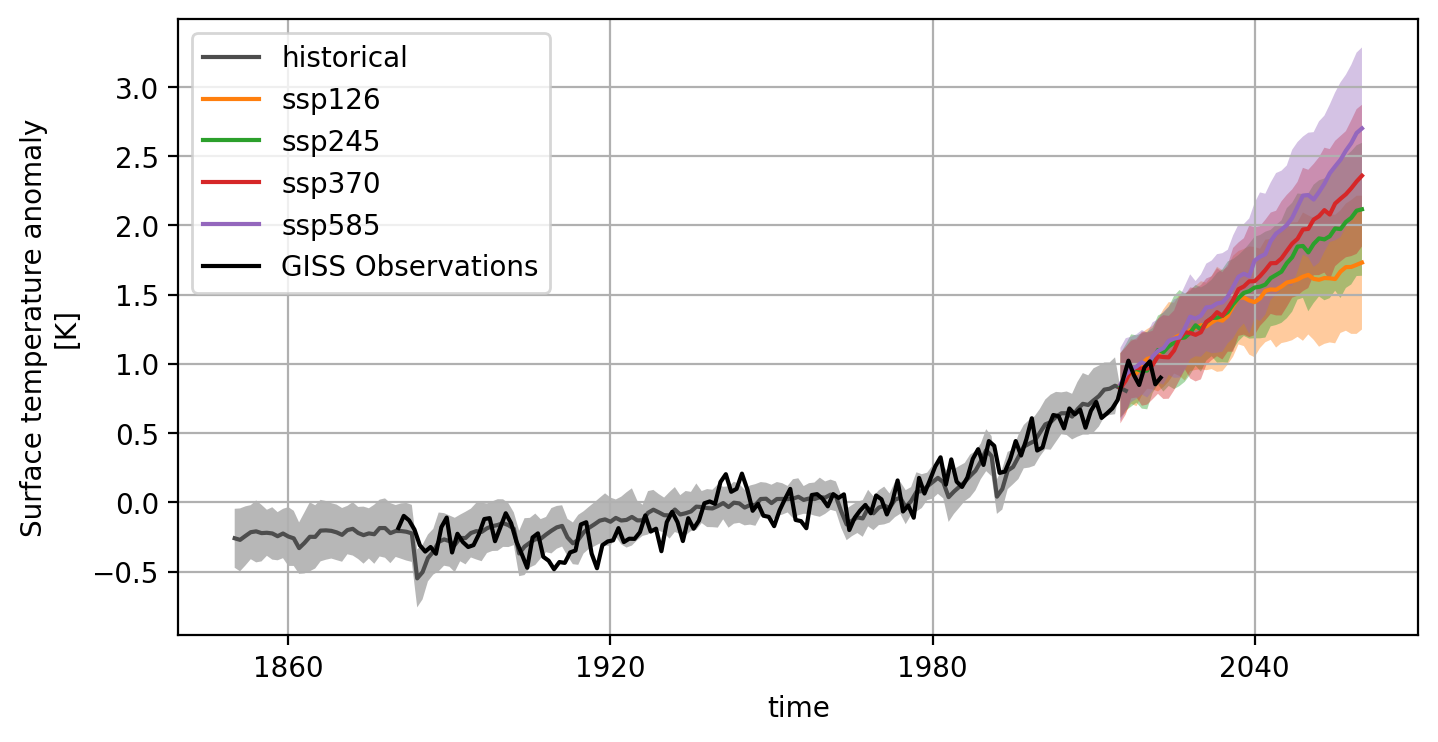

In [29]:
color_dict = {'historical':'0.3', 'ssp126':'C1', 'ssp245':'C2', 'ssp370':'C3', 'ssp585':'C4'}
plt.figure(figsize=[8, 4])
ref = experiments_combined['historical'].squeeze().sel(time=slice('1950', '1980')).mean('time')
for experiment, color in color_dict.items():
    ds = experiments_combined[experiment].squeeze()
    ds_anomaly = ds-ref
    # ds_anomaly.tas.plot(hue='source_id', color=color)
    shaded_line_plot(ds_anomaly.tas, 'source_id', spreads = [2], line_kwargs={'color':color, 'label':experiment})

ds_giss.tempanomaly.pipe(global_mean_giss).coarsen(time=12).mean('time').plot(color='k', label='GISS Observations')
plt.grid()
plt.legend()

In [71]:
# Berkley does not work...TODO: Debug this later
path_berkley = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc"
with fsspec.open(path_berkley) as f:
    ds_berk = xr.open_dataset(f).load()
ds_berk.temperature.mean(['longitude', 'latitude'])


KeyboardInterrupt

